In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from symplecticEuler import *
from calcSpringForces import *
#from tensegpy import *
import tensegpy as tsp
from rotations import *

In [2]:
def set_axis3d(self,lims):
    self.set_xlim3d( lims[0],lims[1] );
    self.set_ylim3d( lims[2],lims[3] );
    self.set_zlim3d( lims[4],lims[5] );
Axes3D.set_axis3d = set_axis3d;

# Initial configuration of structure

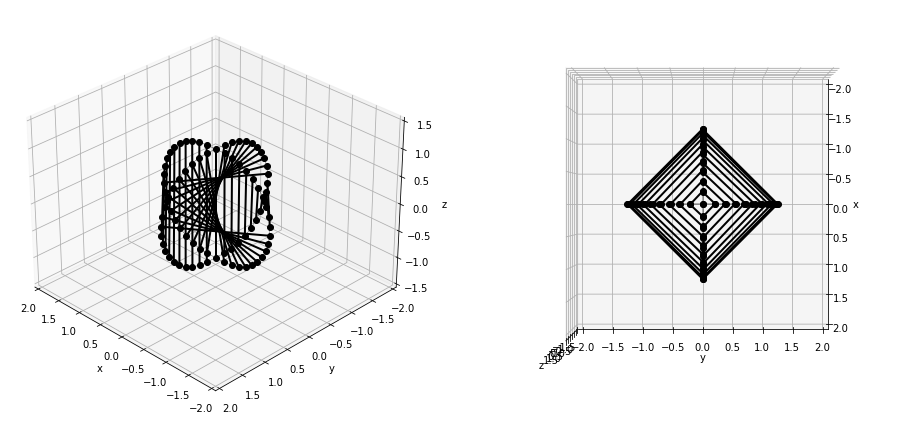

In [3]:
# fan

N = 4; # number of fans
M = 10; # half-number of nodes on each blade

thetas = np.linspace(0,2.*np.pi/2.,2*M);
x = 0*thetas;
y = np.sin(thetas);
z = np.cos(thetas);

blade_base = np.vstack( (x,y,z) );

my_model = tsp.StrutNodeStructure();
    
xyz = blade_base;
xyz[1,:] = xyz[1,:]+.2;
#xyz = rotY(-.2)@xyz;

blades = [];
rounds = [];
rotmat = rotZ(2.*np.pi/N);

# add the central strut. all blades connect to its nodes.
central_nodes = my_model.addVerts(np.array([[0,0,-1],[0,0,1]]).T);
my_model.addStruts( [central_nodes[0]], [central_nodes[1]], stiffness=100.);

for jj in range(N): # make the blades
    tmp = my_model.addVerts(xyz);
    blades.append(tmp);
    rounds.append(tmp);
    xyz = rotmat@xyz;
    my_model.addStruts( tmp[0:-1], tmp[1:] ); # tendons connecting each node in the blade
    my_model.addStruts( central_nodes, [tmp[-1],tmp[0]] ); # tendons connecting the blade to the central strut
    
for jj in range(N): # add struts to each blade
    jnext = (jj+1)%N;
    b1 = blades[jj];
    b2 = blades[jnext];
    my_model.addStruts( b1[0:M],b2[-1:(M-1):-1], stiffness=100.);

for strut in my_model.struts: # make all tendons short, so they contract the structure
    if strut.stiffness == 1.:
        strut.stiffness = 1.;
        #strut.restLeng = 0.95*strut.restLeng;
        strut.restLeng = .1;
    elif strut.stiffness == 100.:
        strut.restLeng = 2.;
        
#%matplotlib qt5
%matplotlib inline
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection='3d')
my_model.plot(color='k',labelVerts=False);
ax.set_axis3d((-2,2,-2,2,-1.5,1.5));
ax.view_init(30,135)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z');

ax = fig.add_subplot(122, projection='3d')
my_model.plot(color='k',labelVerts=False);
ax.set_axis3d((-2,2,-2,2,-1.5,1.5));
ax.view_init(90,0)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z');

plt.show()

# Convert structure to spring-mass system, then perform relaxation

In [4]:
nodes,springList = my_model.divulge();

odeFun_dXdt = lambda X,V: V;
odeFun_dVdt = lambda X,V: calcSpringForces(X,springList)-1.*V;

tspan = np.arange(0,40,.1);
X_init = 1.0*nodes;
V_init = 0.0*nodes;
Xsol,Vsol = symplecticEuler(odeFun_dXdt,odeFun_dVdt,tspan,X_init.copy(),V_init);

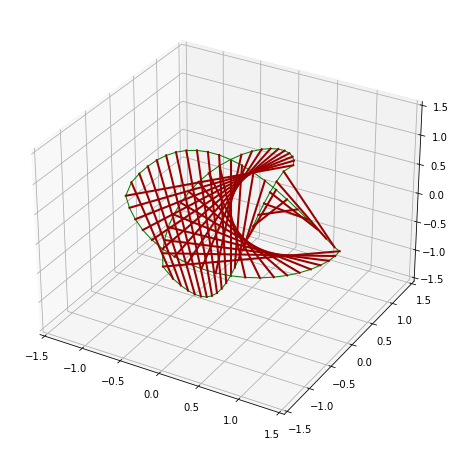

In [5]:
# Plot result

#%matplotlib qt5
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
tsp.plotSpringMassSystem(Xsol[:,-1],springList,detail=1);
ax.set_axis3d((-1.5,1.5,-1.5,1.5,-1.5,1.5));

In [6]:
# If qt5 enabled, this will produce an animation of the spring-mass system in time
%matplotlib qt5
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for kk in range(0,len(tspan),10):
    ax.cla();
    tsp.plotSpringMassSystem( Xsol[:,kk], springList, detail=0, ax=ax)
    
    ax.set_axis3d((-1.5,1.5,-1.5,1.5,-1.5,1.5));

    plt.title("Time=%f"%tspan[kk]);
    plt.pause(0.03);

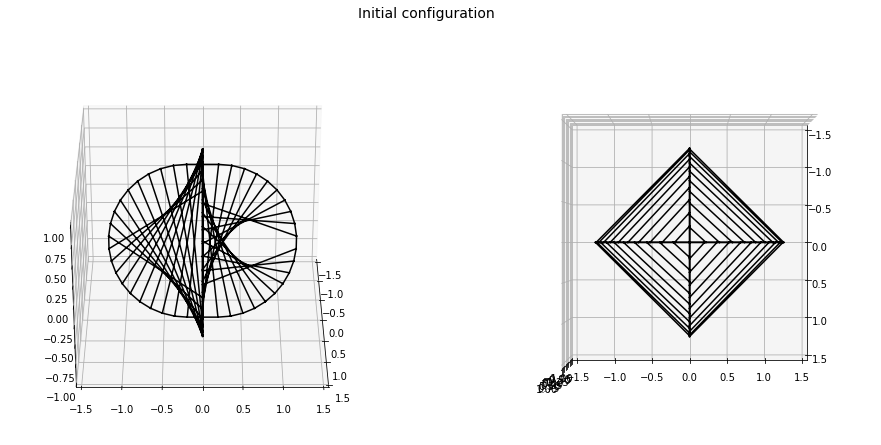

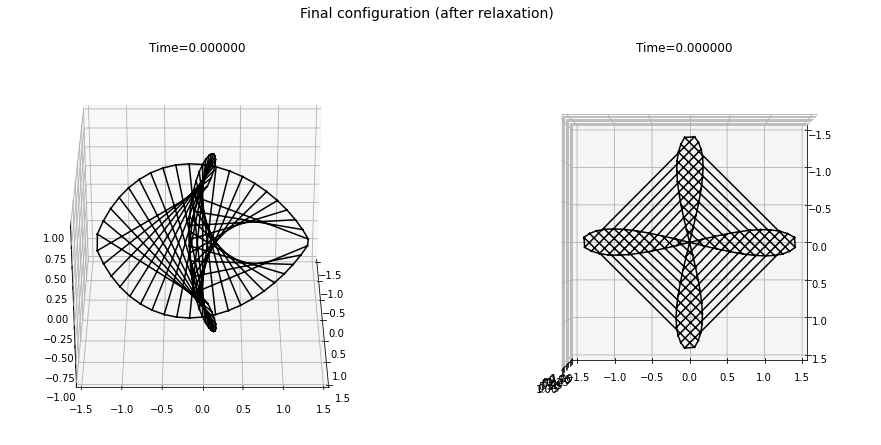

In [7]:
%matplotlib inline
X_final = Xsol[:,-1];


fig = plt.figure(figsize=(16,7))
plt.suptitle('Initial configuration',fontsize=14);

ax = fig.add_subplot(121, projection='3d')
tsp.plotSpringMassSystem( X_init, springList, detail=0, ax=ax)
ax.set_axis3d((-1.5,1.5,-1.5,1.5,-1,1));
ax.view_init(30,0)


ax = fig.add_subplot(122, projection='3d')
tsp.plotSpringMassSystem( X_init, springList, detail=0, ax=ax)
ax.set_axis3d((-1.5,1.5,-1.5,1.5,-1,1));
ax.view_init(90,0)
plt.show();


fig = plt.figure(figsize=(16,7))
plt.suptitle('Final configuration (after relaxation)',fontsize=14);

ax = fig.add_subplot(121, projection='3d')
tsp.plotSpringMassSystem( X_final, springList, detail=0, ax=ax)
ax.set_axis3d((-1.5,1.5,-1.5,1.5,-1,1));
ax.view_init(30,0)
plt.title("Time=%f"%tspan[0]);

ax = fig.add_subplot(122, projection='3d')
tsp.plotSpringMassSystem( X_final, springList, detail=0, ax=ax)
ax.set_axis3d((-1.5,1.5,-1.5,1.5,-1,1));
ax.view_init(90,0)
plt.title("Time=%f"%tspan[0]);
plt.show();